# Deep Convloutional GAN (DCGAN)

- Referecnce : https://github.com/eriklindernoren/PyTorch-GAN

In [5]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Use MNIST Dataset & DataLoader

In [24]:
bs =128

dataset = datasets.MNIST("./mnist", train=True, download=True, 
                         transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True)

torch.Size([128, 1, 32, 32]) tensor([4, 4, 0, 9, 1, 1, 7, 5, 3, 6, 9, 5, 8, 3, 6, 4, 1, 9, 3, 0, 5, 1, 0, 1,
        0, 4, 0, 0, 1, 7, 9, 3, 4, 1, 2, 7, 3, 8, 7, 3, 0, 2, 4, 4, 4, 1, 8, 2,
        6, 5, 0, 6, 0, 4, 3, 2, 7, 5, 8, 3, 2, 3, 1, 6, 1, 4, 1, 7, 9, 2, 9, 3,
        3, 7, 0, 2, 3, 9, 0, 6, 1, 4, 0, 2, 3, 5, 1, 3, 7, 8, 0, 7, 7, 3, 4, 2,
        3, 4, 8, 4, 2, 0, 7, 6, 5, 6, 8, 8, 2, 4, 6, 4, 4, 0, 2, 0, 7, 2, 0, 1,
        1, 7, 9, 1, 6, 4, 6, 9])


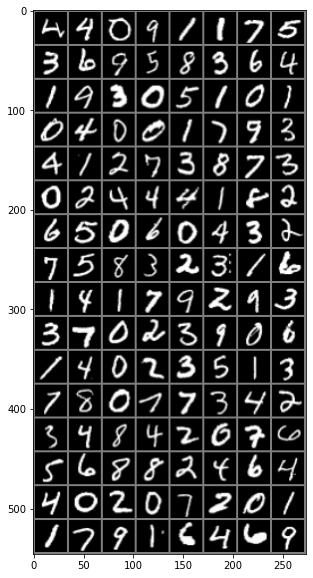

In [25]:
batch = next(iter(dataloader))
len(batch)
print(batch[0].shape, batch[1])

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(batch[0]))

## Define Generator & Discriminator
### Generator architecture
input random vector: 100 dim
* Linear: out_features 128 * 8 * 8
* BatchNorm2d
* Upsample: scale_factor 2
* Conv2d: out_channel: 128, kernel size 3, stride 1, padding 1
* BatchNorm2d
* LeakyReLU: 0.2
* Upsample: scale_factor 2
* Conv2d: out_channel: 64, kernel size 3, stride 1, padding 1
* BatchNorm
* LeakyReLU: 0.2
* Conv2d: out_channel: 1, kernel size 3, stride 1, padding 1
* Tanh

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.fc1 = nn.Linear(100, 128*8*8)
        self.bn1 = nn.BatchNorm2d(128)
        self.up = nn.Upsample(scale_factor=2)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 1, 3, 1, 1)
        self.last_act = nn.Tanh()

    def forward(self, z):
        #### Implement Here ####
        #### Hint : z should be reshaped into 2d before going into bn layer
        z = self.fc1(z)
        img = z.view(-1, 128, 8, 8)
        img = self.bn1(img)
        img = self.act(self.bn2(self.conv1(self.up(img))))
        img = self.act(self.bn3(self.conv2(self.up(img))))
        img = self.last_act(self.conv3(img))
        
        return img

### Discriminator architecture
input: [1 , 32 , 32] image 
* Conv2d: out_channel: 16, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* Conv2d: out_channel: 32, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 64, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 128, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Linear: out_features 1
* Sigmoid

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.block1 = self.make_block(1, 16, False)
        self.block2 = self.make_block(16, 32)
        self.block3 = self.make_block(32, 64)
        self.block4 = self.make_block(64, 128)
        self.fc = nn.Linear(512, 1)
        self.last_act = nn.Sigmoid()
        
        
    def make_block(self, in_channel, out_channel, bn= True):
        #### Implement Here ####
        layers = [
            nn.Conv2d(in_channel, out_channel, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
        ]
        if bn:
            layers.append(nn.BatchNorm2d(out_channel))
        
        return nn.Sequential(*layers) 
        
        
    def forward(self, img):# [1, 32, 32]
        #### Implement Here ####
        img = self.block1(img)
        img = self.block2(img)
        img = self.block3(img)
        img = self.block4(img)
        x = img.view(img.size(0), -1)
        x = self.last_act(self.fc(x))
        
        return x


In [15]:
# Initialize generator and discriminator
G = Generator()
D = Discriminator()

In [16]:
from torchsummary import summary
summary(G, device = 'cpu', batch_size = -1, input_size = (100,))
summary(D, device = 'cpu', batch_size = -1, input_size = (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]         827,392
       BatchNorm2d-2            [-1, 128, 8, 8]             256
          Upsample-3          [-1, 128, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]         147,584
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
          Upsample-7          [-1, 128, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          73,792
       BatchNorm2d-9           [-1, 64, 32, 32]             128
        LeakyReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11            [-1, 1, 32, 32]             577
             Tanh-12            [-1, 1, 32, 32]               0
Total params: 1,049,985
Trainable params: 1,049,985
Non-trainable params: 0
---------------------------

## Weight Initialization

In [19]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1: # Conv2d layer weights init
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1: # BatchNorm2d layer weights init
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# weight initialize
G.apply(weights_init_normal)
D.apply(weights_init_normal)

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## Define loss & Optimizer & model

In [21]:
# Loss function
criterion = torch.nn.BCELoss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.9999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.9999))

## Start Training

In [26]:
G, D = G.to(device), D.to(device)
os.makedirs("./dcgan_images", exist_ok=True)
epochs = 20

[Epoch 0/200] [Batch 0/468] [D loss: 0.647900] [G loss: 1.035566]


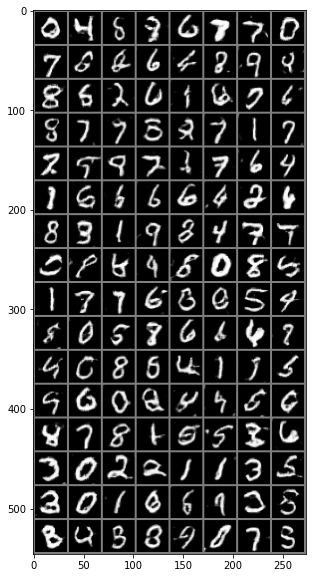

[Epoch 0/200] [Batch 100/468] [D loss: 49.878658] [G loss: 100.000000]
[Epoch 0/200] [Batch 200/468] [D loss: 49.900307] [G loss: 100.000000]
[Epoch 0/200] [Batch 300/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 0/200] [Batch 400/468] [D loss: 49.828827] [G loss: 100.000000]
[Epoch 1/200] [Batch 32/468] [D loss: 49.849602] [G loss: 99.852142]
[Epoch 1/200] [Batch 132/468] [D loss: 49.732178] [G loss: 99.767456]
[Epoch 1/200] [Batch 232/468] [D loss: 50.000000] [G loss: 99.759766]
[Epoch 1/200] [Batch 332/468] [D loss: 49.949318] [G loss: 99.875473]
[Epoch 1/200] [Batch 432/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 2/200] [Batch 64/468] [D loss: 49.943069] [G loss: 99.905212]
[Epoch 2/200] [Batch 164/468] [D loss: 49.946098] [G loss: 100.000000]
[Epoch 2/200] [Batch 264/468] [D loss: 49.887230] [G loss: 99.897438]
[Epoch 2/200] [Batch 364/468] [D loss: 49.754211] [G loss: 99.771820]
[Epoch 2/200] [Batch 464/468] [D loss: 49.836044] [G loss: 100.000000]
[Epoch 3/200] [

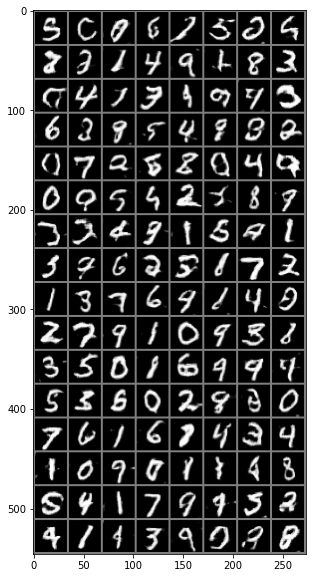

[Epoch 4/200] [Batch 228/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 4/200] [Batch 328/468] [D loss: 49.863319] [G loss: 100.000000]
[Epoch 4/200] [Batch 428/468] [D loss: 49.954765] [G loss: 99.698929]
[Epoch 5/200] [Batch 60/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 5/200] [Batch 160/468] [D loss: 50.000000] [G loss: 99.879814]
[Epoch 5/200] [Batch 260/468] [D loss: 49.934174] [G loss: 100.000000]
[Epoch 5/200] [Batch 360/468] [D loss: 49.881378] [G loss: 100.000000]
[Epoch 5/200] [Batch 460/468] [D loss: 49.912392] [G loss: 100.000000]
[Epoch 6/200] [Batch 92/468] [D loss: 50.000000] [G loss: 99.893478]
[Epoch 6/200] [Batch 192/468] [D loss: 49.942108] [G loss: 99.689354]
[Epoch 6/200] [Batch 292/468] [D loss: 49.894608] [G loss: 100.000000]
[Epoch 6/200] [Batch 392/468] [D loss: 49.838623] [G loss: 100.000000]
[Epoch 7/200] [Batch 24/468] [D loss: 49.952477] [G loss: 100.000000]
[Epoch 7/200] [Batch 124/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 7/200]

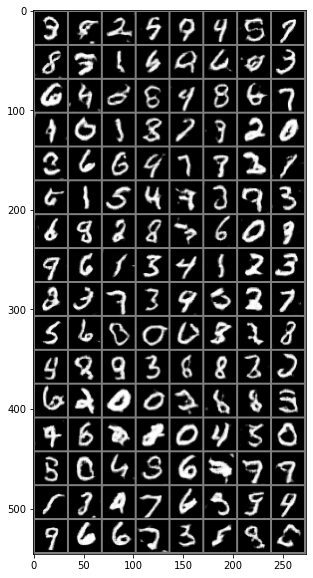

[Epoch 8/200] [Batch 356/468] [D loss: 49.797230] [G loss: 99.878784]
[Epoch 8/200] [Batch 456/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 9/200] [Batch 88/468] [D loss: 49.794342] [G loss: 100.000000]
[Epoch 9/200] [Batch 188/468] [D loss: 49.890938] [G loss: 100.000000]
[Epoch 9/200] [Batch 288/468] [D loss: 49.951557] [G loss: 100.000000]
[Epoch 9/200] [Batch 388/468] [D loss: 49.927517] [G loss: 100.000000]
[Epoch 10/200] [Batch 20/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 10/200] [Batch 120/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 10/200] [Batch 220/468] [D loss: 49.878586] [G loss: 100.000000]
[Epoch 10/200] [Batch 320/468] [D loss: 49.921196] [G loss: 99.890335]
[Epoch 10/200] [Batch 420/468] [D loss: 49.935013] [G loss: 99.890755]
[Epoch 11/200] [Batch 52/468] [D loss: 49.953899] [G loss: 100.000000]
[Epoch 11/200] [Batch 152/468] [D loss: 49.951485] [G loss: 99.855499]
[Epoch 11/200] [Batch 252/468] [D loss: 49.931244] [G loss: 100.000000]
[Epoc

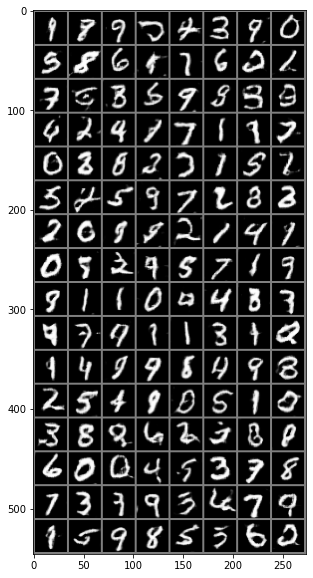

[Epoch 13/200] [Batch 16/468] [D loss: 49.875507] [G loss: 100.000000]
[Epoch 13/200] [Batch 116/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 13/200] [Batch 216/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 13/200] [Batch 316/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 13/200] [Batch 416/468] [D loss: 49.931568] [G loss: 100.000000]
[Epoch 14/200] [Batch 48/468] [D loss: 49.833771] [G loss: 100.000000]
[Epoch 14/200] [Batch 148/468] [D loss: 49.834450] [G loss: 99.765518]
[Epoch 14/200] [Batch 248/468] [D loss: 49.889362] [G loss: 99.883850]
[Epoch 14/200] [Batch 348/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 14/200] [Batch 448/468] [D loss: 49.943932] [G loss: 99.879379]
[Epoch 15/200] [Batch 80/468] [D loss: 49.950058] [G loss: 100.000000]
[Epoch 15/200] [Batch 180/468] [D loss: 50.000000] [G loss: 99.852470]
[Epoch 15/200] [Batch 280/468] [D loss: 49.834679] [G loss: 99.869659]
[Epoch 15/200] [Batch 380/468] [D loss: 50.000000] [G loss: 100.000000]


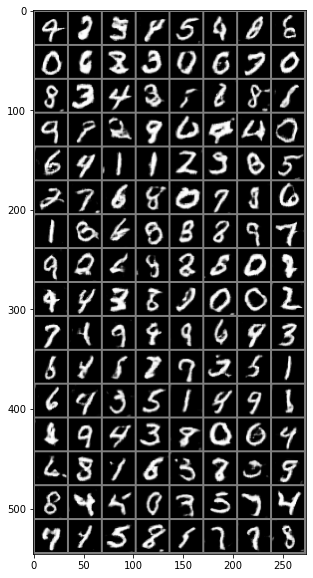

[Epoch 17/200] [Batch 144/468] [D loss: 49.774349] [G loss: 100.000000]
[Epoch 17/200] [Batch 244/468] [D loss: 49.950127] [G loss: 100.000000]
[Epoch 17/200] [Batch 344/468] [D loss: 49.908871] [G loss: 100.000000]
[Epoch 17/200] [Batch 444/468] [D loss: 50.000000] [G loss: 99.791550]
[Epoch 18/200] [Batch 76/468] [D loss: 49.879169] [G loss: 99.891602]
[Epoch 18/200] [Batch 176/468] [D loss: 50.000000] [G loss: 99.869141]
[Epoch 18/200] [Batch 276/468] [D loss: 49.819328] [G loss: 100.000000]
[Epoch 18/200] [Batch 376/468] [D loss: 49.941444] [G loss: 99.808960]
[Epoch 19/200] [Batch 8/468] [D loss: 49.946049] [G loss: 100.000000]
[Epoch 19/200] [Batch 108/468] [D loss: 49.883923] [G loss: 100.000000]
[Epoch 19/200] [Batch 208/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 19/200] [Batch 308/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 19/200] [Batch 408/468] [D loss: 49.875839] [G loss: 99.900688]
[Epoch 20/200] [Batch 40/468] [D loss: 49.866516] [G loss: 99.828720]
[E

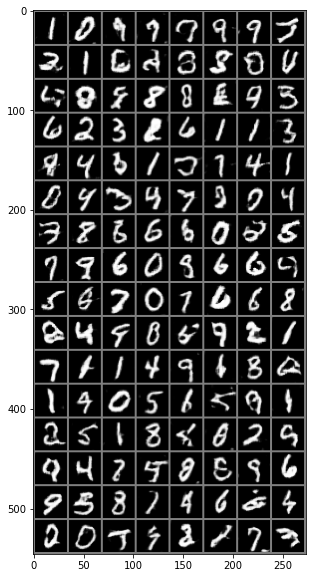

[Epoch 21/200] [Batch 272/468] [D loss: 49.894966] [G loss: 99.908127]
[Epoch 21/200] [Batch 372/468] [D loss: 49.831978] [G loss: 99.902412]
[Epoch 22/200] [Batch 4/468] [D loss: 49.955410] [G loss: 100.000000]
[Epoch 22/200] [Batch 104/468] [D loss: 49.897270] [G loss: 100.000000]
[Epoch 22/200] [Batch 204/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 22/200] [Batch 304/468] [D loss: 49.901382] [G loss: 100.000000]
[Epoch 22/200] [Batch 404/468] [D loss: 49.954544] [G loss: 100.000000]
[Epoch 23/200] [Batch 36/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 23/200] [Batch 136/468] [D loss: 50.000000] [G loss: 99.889534]
[Epoch 23/200] [Batch 236/468] [D loss: 49.927517] [G loss: 99.880341]
[Epoch 23/200] [Batch 336/468] [D loss: 49.953445] [G loss: 99.849792]
[Epoch 23/200] [Batch 436/468] [D loss: 49.941528] [G loss: 100.000000]
[Epoch 24/200] [Batch 68/468] [D loss: 49.774433] [G loss: 99.855087]
[Epoch 24/200] [Batch 168/468] [D loss: 50.000000] [G loss: 100.000000]
[E

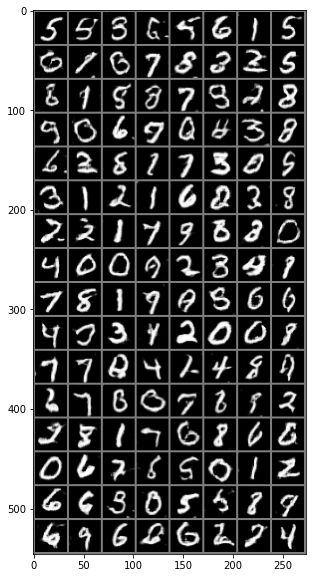

[Epoch 25/200] [Batch 400/468] [D loss: 49.834824] [G loss: 100.000000]
[Epoch 26/200] [Batch 32/468] [D loss: 50.000000] [G loss: 99.802422]
[Epoch 26/200] [Batch 132/468] [D loss: 49.843285] [G loss: 100.000000]
[Epoch 26/200] [Batch 232/468] [D loss: 49.939129] [G loss: 100.000000]
[Epoch 26/200] [Batch 332/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 26/200] [Batch 432/468] [D loss: 49.945366] [G loss: 100.000000]
[Epoch 27/200] [Batch 64/468] [D loss: 49.911190] [G loss: 100.000000]
[Epoch 27/200] [Batch 164/468] [D loss: 49.898129] [G loss: 100.000000]
[Epoch 27/200] [Batch 264/468] [D loss: 49.946503] [G loss: 100.000000]
[Epoch 27/200] [Batch 364/468] [D loss: 50.000000] [G loss: 99.757240]
[Epoch 27/200] [Batch 464/468] [D loss: 49.940804] [G loss: 100.000000]
[Epoch 28/200] [Batch 96/468] [D loss: 49.830151] [G loss: 99.911842]
[Epoch 28/200] [Batch 196/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 28/200] [Batch 296/468] [D loss: 49.955475] [G loss: 99.886017]

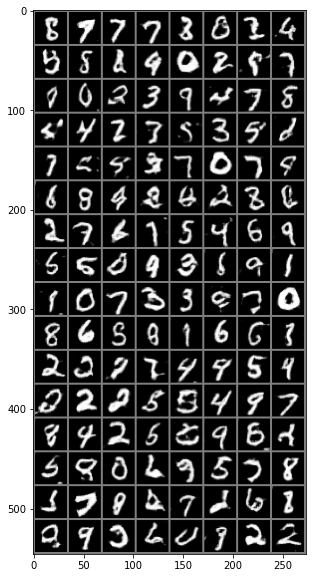

[Epoch 30/200] [Batch 60/468] [D loss: 49.884285] [G loss: 99.911697]
[Epoch 30/200] [Batch 160/468] [D loss: 49.933784] [G loss: 99.687698]
[Epoch 30/200] [Batch 260/468] [D loss: 49.852638] [G loss: 100.000000]
[Epoch 30/200] [Batch 360/468] [D loss: 49.951866] [G loss: 100.000000]
[Epoch 30/200] [Batch 460/468] [D loss: 49.953228] [G loss: 100.000000]
[Epoch 31/200] [Batch 92/468] [D loss: 49.849800] [G loss: 100.000000]
[Epoch 31/200] [Batch 192/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 31/200] [Batch 292/468] [D loss: 49.952087] [G loss: 100.000000]
[Epoch 31/200] [Batch 392/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 32/200] [Batch 24/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 32/200] [Batch 124/468] [D loss: 50.000000] [G loss: 99.901184]
[Epoch 32/200] [Batch 224/468] [D loss: 49.891979] [G loss: 99.779343]
[Epoch 32/200] [Batch 324/468] [D loss: 49.864422] [G loss: 100.000000]
[Epoch 32/200] [Batch 424/468] [D loss: 49.856209] [G loss: 100.000000]

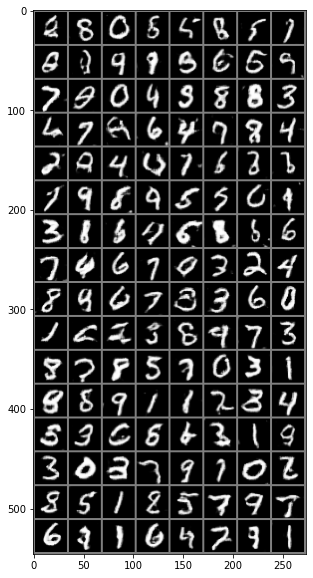

[Epoch 34/200] [Batch 188/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 34/200] [Batch 288/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 34/200] [Batch 388/468] [D loss: 49.890453] [G loss: 99.748352]
[Epoch 35/200] [Batch 20/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 35/200] [Batch 120/468] [D loss: 49.939369] [G loss: 100.000000]
[Epoch 35/200] [Batch 220/468] [D loss: 49.954361] [G loss: 99.830048]
[Epoch 35/200] [Batch 320/468] [D loss: 49.950516] [G loss: 100.000000]
[Epoch 35/200] [Batch 420/468] [D loss: 49.953575] [G loss: 100.000000]
[Epoch 36/200] [Batch 52/468] [D loss: 50.000000] [G loss: 99.910583]
[Epoch 36/200] [Batch 152/468] [D loss: 49.843796] [G loss: 100.000000]
[Epoch 36/200] [Batch 252/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 36/200] [Batch 352/468] [D loss: 49.946373] [G loss: 99.911720]
[Epoch 36/200] [Batch 452/468] [D loss: 49.887257] [G loss: 100.000000]
[Epoch 37/200] [Batch 84/468] [D loss: 49.952599] [G loss: 100.000000]

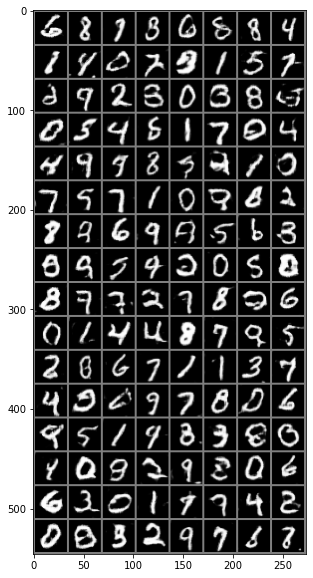

[Epoch 38/200] [Batch 316/468] [D loss: 49.940487] [G loss: 100.000000]
[Epoch 38/200] [Batch 416/468] [D loss: 49.937721] [G loss: 99.877060]
[Epoch 39/200] [Batch 48/468] [D loss: 49.809834] [G loss: 99.783829]
[Epoch 39/200] [Batch 148/468] [D loss: 49.892284] [G loss: 100.000000]
[Epoch 39/200] [Batch 248/468] [D loss: 49.934952] [G loss: 99.904892]
[Epoch 39/200] [Batch 348/468] [D loss: 49.816483] [G loss: 100.000000]
[Epoch 39/200] [Batch 448/468] [D loss: 49.913887] [G loss: 100.000000]
[Epoch 40/200] [Batch 80/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 40/200] [Batch 180/468] [D loss: 49.941475] [G loss: 100.000000]
[Epoch 40/200] [Batch 280/468] [D loss: 49.885361] [G loss: 99.622772]
[Epoch 40/200] [Batch 380/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 41/200] [Batch 12/468] [D loss: 49.953064] [G loss: 99.593811]
[Epoch 41/200] [Batch 112/468] [D loss: 49.954765] [G loss: 99.839989]
[Epoch 41/200] [Batch 212/468] [D loss: 49.880310] [G loss: 99.877258]
[E

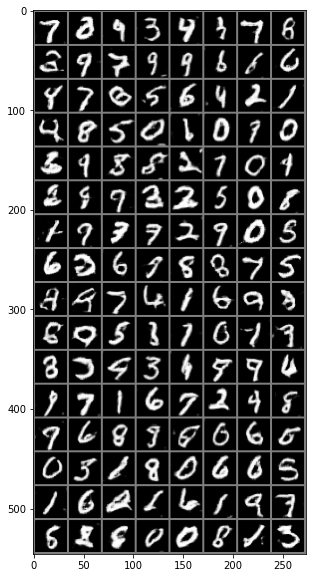

[Epoch 42/200] [Batch 444/468] [D loss: 50.000000] [G loss: 99.894333]
[Epoch 43/200] [Batch 76/468] [D loss: 49.925152] [G loss: 99.747421]
[Epoch 43/200] [Batch 176/468] [D loss: 49.905743] [G loss: 99.903824]
[Epoch 43/200] [Batch 276/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 43/200] [Batch 376/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 44/200] [Batch 8/468] [D loss: 49.841431] [G loss: 100.000000]
[Epoch 44/200] [Batch 108/468] [D loss: 49.892567] [G loss: 99.896042]
[Epoch 44/200] [Batch 208/468] [D loss: 49.734604] [G loss: 99.909134]
[Epoch 44/200] [Batch 308/468] [D loss: 49.952667] [G loss: 100.000000]
[Epoch 44/200] [Batch 408/468] [D loss: 49.830238] [G loss: 100.000000]
[Epoch 45/200] [Batch 40/468] [D loss: 49.941292] [G loss: 99.891365]
[Epoch 45/200] [Batch 140/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 45/200] [Batch 240/468] [D loss: 49.925468] [G loss: 99.703056]
[Epoch 45/200] [Batch 340/468] [D loss: 49.953197] [G loss: 100.000000]
[Ep

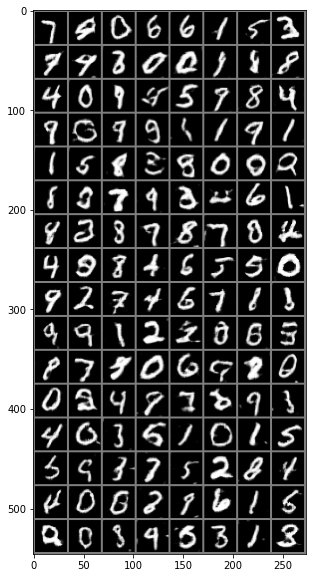

[Epoch 47/200] [Batch 104/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 47/200] [Batch 204/468] [D loss: 49.948299] [G loss: 100.000000]
[Epoch 47/200] [Batch 304/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 47/200] [Batch 404/468] [D loss: 49.790604] [G loss: 99.887314]
[Epoch 48/200] [Batch 36/468] [D loss: 49.908913] [G loss: 99.781151]
[Epoch 48/200] [Batch 136/468] [D loss: 49.934155] [G loss: 100.000000]
[Epoch 48/200] [Batch 236/468] [D loss: 49.954433] [G loss: 99.883171]
[Epoch 48/200] [Batch 336/468] [D loss: 49.933685] [G loss: 100.000000]
[Epoch 48/200] [Batch 436/468] [D loss: 49.938705] [G loss: 100.000000]
[Epoch 49/200] [Batch 68/468] [D loss: 50.000000] [G loss: 99.831383]
[Epoch 49/200] [Batch 168/468] [D loss: 49.952301] [G loss: 99.869690]
[Epoch 49/200] [Batch 268/468] [D loss: 49.787300] [G loss: 100.000000]
[Epoch 49/200] [Batch 368/468] [D loss: 49.939720] [G loss: 100.000000]
[Epoch 50/200] [Batch 0/468] [D loss: 49.946121] [G loss: 100.000000]
[

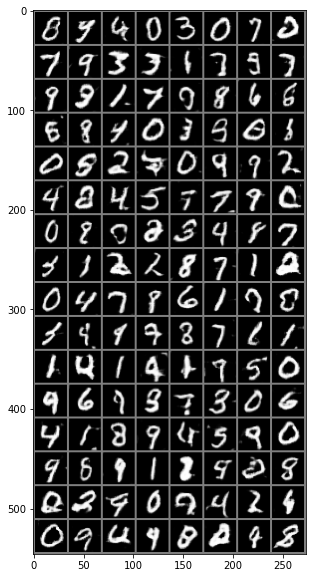

[Epoch 51/200] [Batch 232/468] [D loss: 50.000000] [G loss: 99.854187]
[Epoch 51/200] [Batch 332/468] [D loss: 49.951557] [G loss: 100.000000]
[Epoch 51/200] [Batch 432/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 52/200] [Batch 64/468] [D loss: 49.788261] [G loss: 99.889732]
[Epoch 52/200] [Batch 164/468] [D loss: 49.955837] [G loss: 99.773560]
[Epoch 52/200] [Batch 264/468] [D loss: 49.955906] [G loss: 99.872528]
[Epoch 52/200] [Batch 364/468] [D loss: 49.954491] [G loss: 99.907227]
[Epoch 52/200] [Batch 464/468] [D loss: 49.930473] [G loss: 99.871460]
[Epoch 53/200] [Batch 96/468] [D loss: 49.949280] [G loss: 100.000000]
[Epoch 53/200] [Batch 196/468] [D loss: 50.000000] [G loss: 99.909790]
[Epoch 53/200] [Batch 296/468] [D loss: 49.900307] [G loss: 100.000000]
[Epoch 53/200] [Batch 396/468] [D loss: 49.858475] [G loss: 100.000000]
[Epoch 54/200] [Batch 28/468] [D loss: 49.934769] [G loss: 99.802025]
[Epoch 54/200] [Batch 128/468] [D loss: 49.890984] [G loss: 100.000000]
[Ep

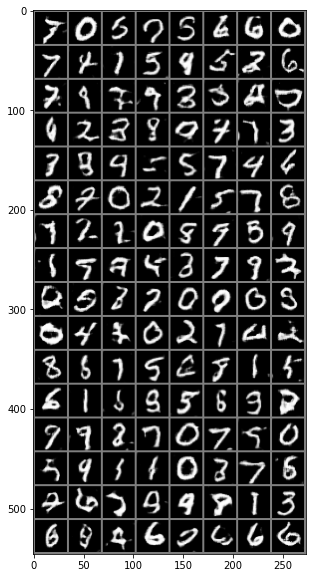

[Epoch 55/200] [Batch 360/468] [D loss: 49.952599] [G loss: 100.000000]
[Epoch 55/200] [Batch 460/468] [D loss: 49.843830] [G loss: 100.000000]
[Epoch 56/200] [Batch 92/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 56/200] [Batch 192/468] [D loss: 49.716759] [G loss: 100.000000]
[Epoch 56/200] [Batch 292/468] [D loss: 49.892624] [G loss: 99.889725]
[Epoch 56/200] [Batch 392/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 57/200] [Batch 24/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 57/200] [Batch 124/468] [D loss: 49.885551] [G loss: 99.847641]
[Epoch 57/200] [Batch 224/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 57/200] [Batch 324/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 57/200] [Batch 424/468] [D loss: 49.867142] [G loss: 100.000000]
[Epoch 58/200] [Batch 56/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 58/200] [Batch 156/468] [D loss: 49.779930] [G loss: 99.793457]
[Epoch 58/200] [Batch 256/468] [D loss: 50.000000] [G loss: 100.000000

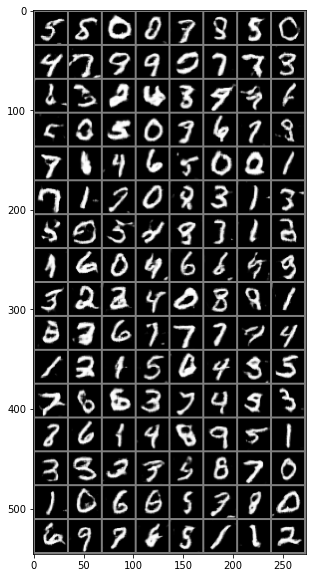

[Epoch 60/200] [Batch 20/468] [D loss: 49.895782] [G loss: 99.908821]
[Epoch 60/200] [Batch 120/468] [D loss: 49.945648] [G loss: 100.000000]
[Epoch 60/200] [Batch 220/468] [D loss: 49.878532] [G loss: 100.000000]
[Epoch 60/200] [Batch 320/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 60/200] [Batch 420/468] [D loss: 50.000000] [G loss: 99.865417]
[Epoch 61/200] [Batch 52/468] [D loss: 49.886703] [G loss: 100.000000]
[Epoch 61/200] [Batch 152/468] [D loss: 49.896248] [G loss: 100.000000]
[Epoch 61/200] [Batch 252/468] [D loss: 49.832497] [G loss: 99.909454]
[Epoch 61/200] [Batch 352/468] [D loss: 50.000000] [G loss: 99.831680]
[Epoch 61/200] [Batch 452/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 62/200] [Batch 84/468] [D loss: 49.875507] [G loss: 100.000000]
[Epoch 62/200] [Batch 184/468] [D loss: 49.908463] [G loss: 100.000000]
[Epoch 62/200] [Batch 284/468] [D loss: 49.955906] [G loss: 99.884979]
[Epoch 62/200] [Batch 384/468] [D loss: 49.955742] [G loss: 100.000000]


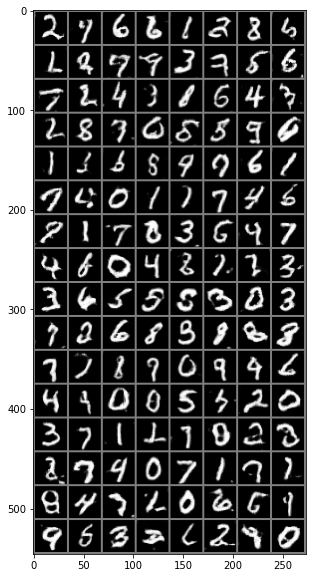

[Epoch 64/200] [Batch 148/468] [D loss: 49.954121] [G loss: 99.904907]
[Epoch 64/200] [Batch 248/468] [D loss: 50.000000] [G loss: 99.781540]
[Epoch 64/200] [Batch 348/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 64/200] [Batch 448/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 65/200] [Batch 80/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 65/200] [Batch 180/468] [D loss: 50.000000] [G loss: 99.911453]
[Epoch 65/200] [Batch 280/468] [D loss: 49.899639] [G loss: 99.891899]
[Epoch 65/200] [Batch 380/468] [D loss: 49.938995] [G loss: 100.000000]
[Epoch 66/200] [Batch 12/468] [D loss: 49.860130] [G loss: 100.000000]
[Epoch 66/200] [Batch 112/468] [D loss: 49.886925] [G loss: 99.865356]
[Epoch 66/200] [Batch 212/468] [D loss: 49.950985] [G loss: 100.000000]
[Epoch 66/200] [Batch 312/468] [D loss: 50.000000] [G loss: 99.870773]
[Epoch 66/200] [Batch 412/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 67/200] [Batch 44/468] [D loss: 50.000000] [G loss: 100.000000]
[

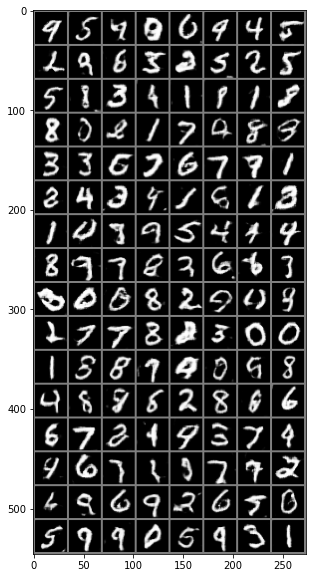

[Epoch 68/200] [Batch 276/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 68/200] [Batch 376/468] [D loss: 50.000000] [G loss: 99.749535]
[Epoch 69/200] [Batch 8/468] [D loss: 49.948040] [G loss: 100.000000]
[Epoch 69/200] [Batch 108/468] [D loss: 49.934704] [G loss: 100.000000]
[Epoch 69/200] [Batch 208/468] [D loss: 49.954361] [G loss: 100.000000]
[Epoch 69/200] [Batch 308/468] [D loss: 49.878014] [G loss: 100.000000]
[Epoch 69/200] [Batch 408/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 70/200] [Batch 40/468] [D loss: 49.953796] [G loss: 100.000000]
[Epoch 70/200] [Batch 140/468] [D loss: 49.901062] [G loss: 100.000000]
[Epoch 70/200] [Batch 240/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 70/200] [Batch 340/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 70/200] [Batch 440/468] [D loss: 49.944069] [G loss: 100.000000]
[Epoch 71/200] [Batch 72/468] [D loss: 49.944195] [G loss: 99.868408]
[Epoch 71/200] [Batch 172/468] [D loss: 49.905521] [G loss: 100.000000

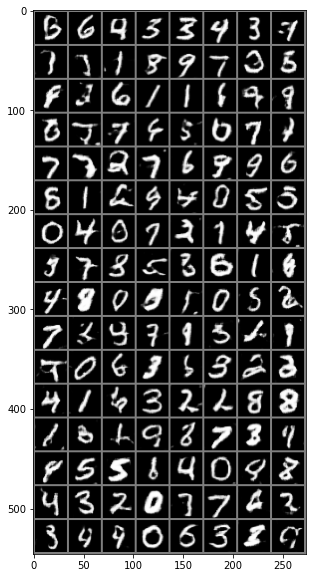

[Epoch 72/200] [Batch 404/468] [D loss: 49.856133] [G loss: 99.750778]
[Epoch 73/200] [Batch 36/468] [D loss: 49.894142] [G loss: 99.840752]
[Epoch 73/200] [Batch 136/468] [D loss: 49.886070] [G loss: 99.894592]
[Epoch 73/200] [Batch 236/468] [D loss: 49.918224] [G loss: 100.000000]
[Epoch 73/200] [Batch 336/468] [D loss: 49.955147] [G loss: 100.000000]
[Epoch 73/200] [Batch 436/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 74/200] [Batch 68/468] [D loss: 49.950882] [G loss: 100.000000]
[Epoch 74/200] [Batch 168/468] [D loss: 49.954708] [G loss: 100.000000]
[Epoch 74/200] [Batch 268/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 74/200] [Batch 368/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 75/200] [Batch 0/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 75/200] [Batch 100/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 75/200] [Batch 200/468] [D loss: 50.000000] [G loss: 99.774078]
[Epoch 75/200] [Batch 300/468] [D loss: 49.933113] [G loss: 100.000000]


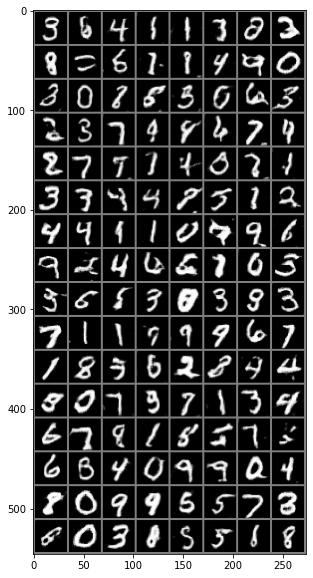

[Epoch 77/200] [Batch 64/468] [D loss: 49.931511] [G loss: 99.897621]
[Epoch 77/200] [Batch 164/468] [D loss: 49.945419] [G loss: 100.000000]
[Epoch 77/200] [Batch 264/468] [D loss: 49.938705] [G loss: 100.000000]
[Epoch 77/200] [Batch 364/468] [D loss: 50.000000] [G loss: 99.894714]
[Epoch 77/200] [Batch 464/468] [D loss: 49.940502] [G loss: 100.000000]
[Epoch 78/200] [Batch 96/468] [D loss: 49.952087] [G loss: 99.854698]
[Epoch 78/200] [Batch 196/468] [D loss: 50.000000] [G loss: 99.875099]
[Epoch 78/200] [Batch 296/468] [D loss: 49.848686] [G loss: 100.000000]
[Epoch 78/200] [Batch 396/468] [D loss: 49.900627] [G loss: 99.899094]
[Epoch 79/200] [Batch 28/468] [D loss: 49.793579] [G loss: 100.000000]
[Epoch 79/200] [Batch 128/468] [D loss: 49.952358] [G loss: 100.000000]
[Epoch 79/200] [Batch 228/468] [D loss: 49.946404] [G loss: 99.833359]
[Epoch 79/200] [Batch 328/468] [D loss: 49.883801] [G loss: 100.000000]
[Epoch 79/200] [Batch 428/468] [D loss: 50.000000] [G loss: 99.908752]
[E

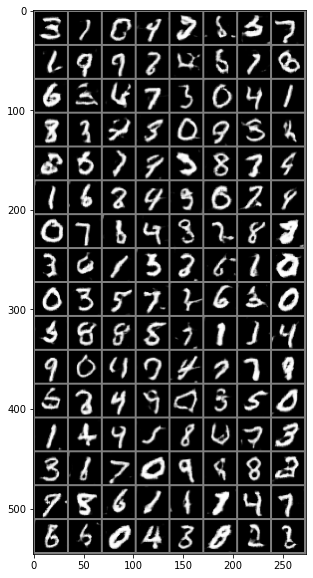

[Epoch 81/200] [Batch 192/468] [D loss: 50.000000] [G loss: 99.860992]
[Epoch 81/200] [Batch 292/468] [D loss: 49.876480] [G loss: 99.776138]
[Epoch 81/200] [Batch 392/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 82/200] [Batch 24/468] [D loss: 49.955360] [G loss: 99.885834]
[Epoch 82/200] [Batch 124/468] [D loss: 49.950684] [G loss: 100.000000]
[Epoch 82/200] [Batch 224/468] [D loss: 49.940910] [G loss: 100.000000]
[Epoch 82/200] [Batch 324/468] [D loss: 50.000000] [G loss: 99.910049]
[Epoch 82/200] [Batch 424/468] [D loss: 49.788593] [G loss: 99.906616]
[Epoch 83/200] [Batch 56/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 83/200] [Batch 156/468] [D loss: 49.955143] [G loss: 100.000000]
[Epoch 83/200] [Batch 256/468] [D loss: 50.000000] [G loss: 99.905563]
[Epoch 83/200] [Batch 356/468] [D loss: 49.825752] [G loss: 100.000000]
[Epoch 83/200] [Batch 456/468] [D loss: 49.900490] [G loss: 99.862602]
[Epoch 84/200] [Batch 88/468] [D loss: 49.948967] [G loss: 99.910698]
[Ep

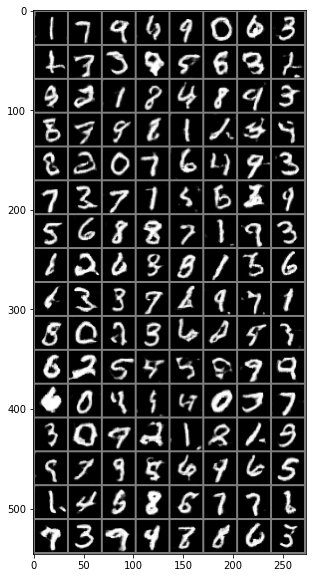

[Epoch 85/200] [Batch 320/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 85/200] [Batch 420/468] [D loss: 49.788506] [G loss: 100.000000]
[Epoch 86/200] [Batch 52/468] [D loss: 49.938171] [G loss: 99.904999]
[Epoch 86/200] [Batch 152/468] [D loss: 49.845230] [G loss: 99.881012]
[Epoch 86/200] [Batch 252/468] [D loss: 49.935318] [G loss: 99.907288]
[Epoch 86/200] [Batch 352/468] [D loss: 50.000000] [G loss: 99.900177]
[Epoch 86/200] [Batch 452/468] [D loss: 49.951214] [G loss: 100.000000]
[Epoch 87/200] [Batch 84/468] [D loss: 50.000000] [G loss: 99.867439]
[Epoch 87/200] [Batch 184/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 87/200] [Batch 284/468] [D loss: 49.893291] [G loss: 99.879356]
[Epoch 87/200] [Batch 384/468] [D loss: 49.863853] [G loss: 100.000000]
[Epoch 88/200] [Batch 16/468] [D loss: 49.756954] [G loss: 99.872604]
[Epoch 88/200] [Batch 116/468] [D loss: 49.884644] [G loss: 100.000000]
[Epoch 88/200] [Batch 216/468] [D loss: 49.826649] [G loss: 99.762733]
[Ep

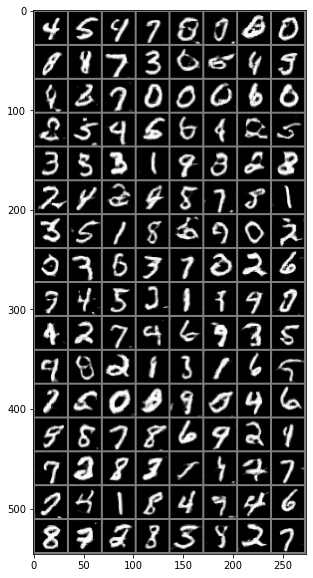

[Epoch 89/200] [Batch 448/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 90/200] [Batch 80/468] [D loss: 49.752884] [G loss: 99.904488]
[Epoch 90/200] [Batch 180/468] [D loss: 49.866287] [G loss: 100.000000]
[Epoch 90/200] [Batch 280/468] [D loss: 50.000000] [G loss: 99.880699]
[Epoch 90/200] [Batch 380/468] [D loss: 49.856815] [G loss: 99.789337]
[Epoch 91/200] [Batch 12/468] [D loss: 50.000000] [G loss: 99.816704]
[Epoch 91/200] [Batch 112/468] [D loss: 49.954872] [G loss: 99.908203]
[Epoch 91/200] [Batch 212/468] [D loss: 49.852554] [G loss: 100.000000]
[Epoch 91/200] [Batch 312/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 91/200] [Batch 412/468] [D loss: 49.936794] [G loss: 99.889526]
[Epoch 92/200] [Batch 44/468] [D loss: 49.896751] [G loss: 99.900681]
[Epoch 92/200] [Batch 144/468] [D loss: 49.896698] [G loss: 99.728897]
[Epoch 92/200] [Batch 244/468] [D loss: 49.880276] [G loss: 100.000000]
[Epoch 92/200] [Batch 344/468] [D loss: 49.881557] [G loss: 100.000000]
[Ep

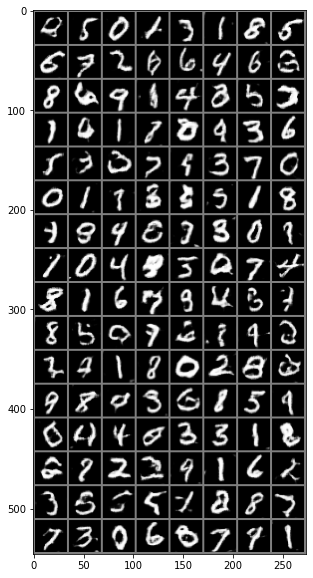

[Epoch 94/200] [Batch 108/468] [D loss: 49.862022] [G loss: 100.000000]
[Epoch 94/200] [Batch 208/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 94/200] [Batch 308/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 94/200] [Batch 408/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 95/200] [Batch 40/468] [D loss: 49.942310] [G loss: 99.807281]
[Epoch 95/200] [Batch 140/468] [D loss: 49.810131] [G loss: 100.000000]
[Epoch 95/200] [Batch 240/468] [D loss: 50.000000] [G loss: 99.860237]
[Epoch 95/200] [Batch 340/468] [D loss: 49.823479] [G loss: 100.000000]
[Epoch 95/200] [Batch 440/468] [D loss: 49.883129] [G loss: 100.000000]
[Epoch 96/200] [Batch 72/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 96/200] [Batch 172/468] [D loss: 50.000000] [G loss: 99.781036]
[Epoch 96/200] [Batch 272/468] [D loss: 49.846367] [G loss: 100.000000]
[Epoch 96/200] [Batch 372/468] [D loss: 49.955379] [G loss: 100.000000]
[Epoch 97/200] [Batch 4/468] [D loss: 49.921196] [G loss: 99.658600]


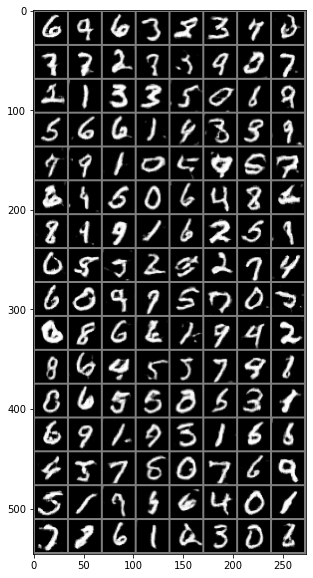

[Epoch 98/200] [Batch 236/468] [D loss: 49.877434] [G loss: 100.000000]
[Epoch 98/200] [Batch 336/468] [D loss: 49.948563] [G loss: 99.906403]
[Epoch 98/200] [Batch 436/468] [D loss: 50.000000] [G loss: 99.814133]
[Epoch 99/200] [Batch 68/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 99/200] [Batch 168/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 99/200] [Batch 268/468] [D loss: 49.952667] [G loss: 100.000000]
[Epoch 99/200] [Batch 368/468] [D loss: 50.000000] [G loss: 99.845993]
[Epoch 100/200] [Batch 0/468] [D loss: 49.844913] [G loss: 100.000000]
[Epoch 100/200] [Batch 100/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 100/200] [Batch 200/468] [D loss: 49.954903] [G loss: 100.000000]
[Epoch 100/200] [Batch 300/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 100/200] [Batch 400/468] [D loss: 50.000000] [G loss: 99.899612]
[Epoch 101/200] [Batch 32/468] [D loss: 49.902039] [G loss: 100.000000]
[Epoch 101/200] [Batch 132/468] [D loss: 49.831001] [G loss: 99.83

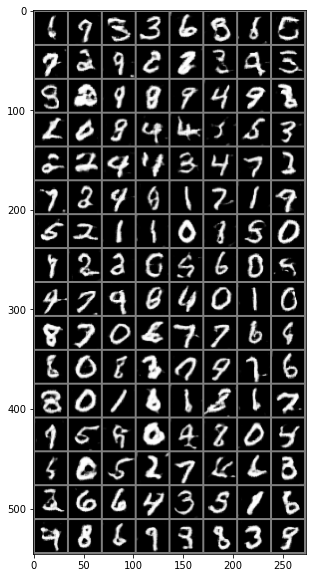

[Epoch 102/200] [Batch 364/468] [D loss: 50.000000] [G loss: 99.901550]
[Epoch 102/200] [Batch 464/468] [D loss: 49.950058] [G loss: 100.000000]
[Epoch 103/200] [Batch 96/468] [D loss: 50.000000] [G loss: 99.911316]
[Epoch 103/200] [Batch 196/468] [D loss: 49.928978] [G loss: 100.000000]
[Epoch 103/200] [Batch 296/468] [D loss: 49.843063] [G loss: 99.905632]
[Epoch 103/200] [Batch 396/468] [D loss: 49.935425] [G loss: 100.000000]
[Epoch 104/200] [Batch 28/468] [D loss: 50.000000] [G loss: 99.885620]
[Epoch 104/200] [Batch 128/468] [D loss: 49.931244] [G loss: 100.000000]
[Epoch 104/200] [Batch 228/468] [D loss: 49.928452] [G loss: 100.000000]
[Epoch 104/200] [Batch 328/468] [D loss: 49.920506] [G loss: 100.000000]
[Epoch 104/200] [Batch 428/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 105/200] [Batch 60/468] [D loss: 49.924622] [G loss: 100.000000]
[Epoch 105/200] [Batch 160/468] [D loss: 49.899666] [G loss: 99.889709]
[Epoch 105/200] [Batch 260/468] [D loss: 50.000000] [G loss

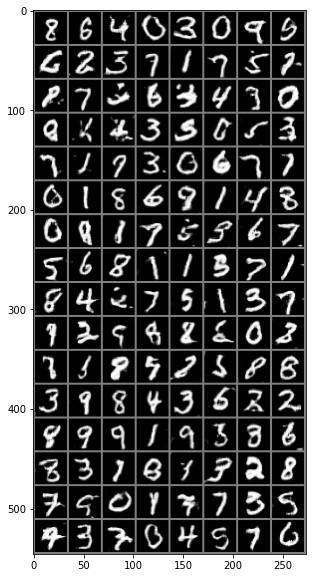

[Epoch 107/200] [Batch 24/468] [D loss: 49.949341] [G loss: 99.781960]
[Epoch 107/200] [Batch 124/468] [D loss: 49.884323] [G loss: 99.871826]
[Epoch 107/200] [Batch 224/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 107/200] [Batch 324/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 107/200] [Batch 424/468] [D loss: 49.902489] [G loss: 100.000000]
[Epoch 108/200] [Batch 56/468] [D loss: 49.910770] [G loss: 99.900742]
[Epoch 108/200] [Batch 156/468] [D loss: 49.828686] [G loss: 100.000000]
[Epoch 108/200] [Batch 256/468] [D loss: 50.000000] [G loss: 99.850082]
[Epoch 108/200] [Batch 356/468] [D loss: 49.939129] [G loss: 100.000000]
[Epoch 108/200] [Batch 456/468] [D loss: 49.732407] [G loss: 100.000000]
[Epoch 109/200] [Batch 88/468] [D loss: 49.927048] [G loss: 99.849648]
[Epoch 109/200] [Batch 188/468] [D loss: 49.856483] [G loss: 100.000000]
[Epoch 109/200] [Batch 288/468] [D loss: 49.782120] [G loss: 100.000000]
[Epoch 109/200] [Batch 388/468] [D loss: 49.864822] [G loss

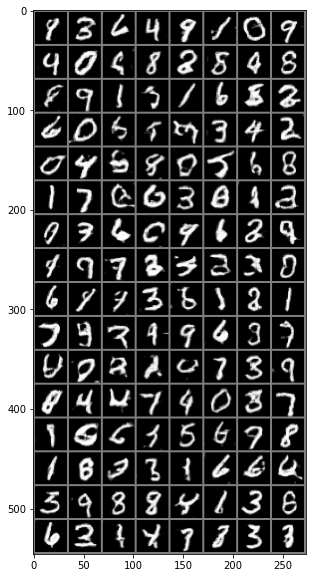

[Epoch 111/200] [Batch 152/468] [D loss: 49.900982] [G loss: 100.000000]
[Epoch 111/200] [Batch 252/468] [D loss: 49.887539] [G loss: 100.000000]
[Epoch 111/200] [Batch 352/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 111/200] [Batch 452/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 112/200] [Batch 84/468] [D loss: 49.881477] [G loss: 99.897865]
[Epoch 112/200] [Batch 184/468] [D loss: 49.911018] [G loss: 99.859886]
[Epoch 112/200] [Batch 284/468] [D loss: 49.917797] [G loss: 100.000000]
[Epoch 112/200] [Batch 384/468] [D loss: 49.936516] [G loss: 100.000000]
[Epoch 113/200] [Batch 16/468] [D loss: 49.795444] [G loss: 100.000000]
[Epoch 113/200] [Batch 116/468] [D loss: 49.844128] [G loss: 100.000000]
[Epoch 113/200] [Batch 216/468] [D loss: 49.952240] [G loss: 100.000000]
[Epoch 113/200] [Batch 316/468] [D loss: 49.894943] [G loss: 99.906570]
[Epoch 113/200] [Batch 416/468] [D loss: 49.950825] [G loss: 99.789429]
[Epoch 114/200] [Batch 48/468] [D loss: 50.000000] [G los

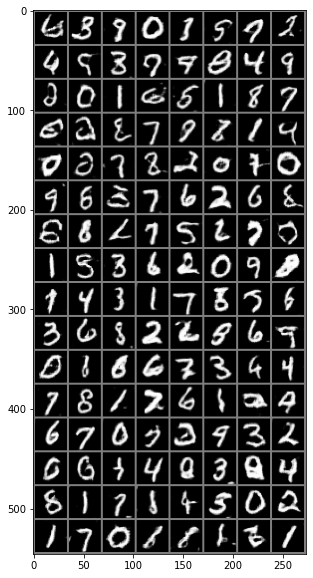

[Epoch 115/200] [Batch 280/468] [D loss: 49.943745] [G loss: 99.909348]
[Epoch 115/200] [Batch 380/468] [D loss: 49.948223] [G loss: 100.000000]
[Epoch 116/200] [Batch 12/468] [D loss: 49.895065] [G loss: 100.000000]
[Epoch 116/200] [Batch 112/468] [D loss: 49.942253] [G loss: 100.000000]
[Epoch 116/200] [Batch 212/468] [D loss: 49.896019] [G loss: 100.000000]
[Epoch 116/200] [Batch 312/468] [D loss: 49.902626] [G loss: 100.000000]
[Epoch 116/200] [Batch 412/468] [D loss: 49.954468] [G loss: 100.000000]
[Epoch 117/200] [Batch 44/468] [D loss: 49.896687] [G loss: 100.000000]
[Epoch 117/200] [Batch 144/468] [D loss: 49.842762] [G loss: 100.000000]
[Epoch 117/200] [Batch 244/468] [D loss: 49.905769] [G loss: 100.000000]
[Epoch 117/200] [Batch 344/468] [D loss: 49.955147] [G loss: 100.000000]
[Epoch 117/200] [Batch 444/468] [D loss: 49.859146] [G loss: 100.000000]
[Epoch 118/200] [Batch 76/468] [D loss: 49.934219] [G loss: 100.000000]
[Epoch 118/200] [Batch 176/468] [D loss: 50.000000] [G 

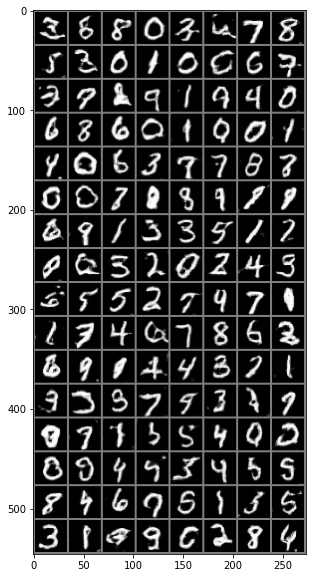

[Epoch 119/200] [Batch 408/468] [D loss: 49.904270] [G loss: 99.874878]
[Epoch 120/200] [Batch 40/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 120/200] [Batch 140/468] [D loss: 49.851524] [G loss: 100.000000]
[Epoch 120/200] [Batch 240/468] [D loss: 49.949280] [G loss: 100.000000]
[Epoch 120/200] [Batch 340/468] [D loss: 49.954529] [G loss: 99.911514]
[Epoch 120/200] [Batch 440/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 121/200] [Batch 72/468] [D loss: 49.884830] [G loss: 100.000000]
[Epoch 121/200] [Batch 172/468] [D loss: 49.936516] [G loss: 100.000000]
[Epoch 121/200] [Batch 272/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 121/200] [Batch 372/468] [D loss: 49.865707] [G loss: 99.908379]
[Epoch 122/200] [Batch 4/468] [D loss: 49.944508] [G loss: 100.000000]
[Epoch 122/200] [Batch 104/468] [D loss: 49.850540] [G loss: 100.000000]
[Epoch 122/200] [Batch 204/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 122/200] [Batch 304/468] [D loss: 49.894978] [G los

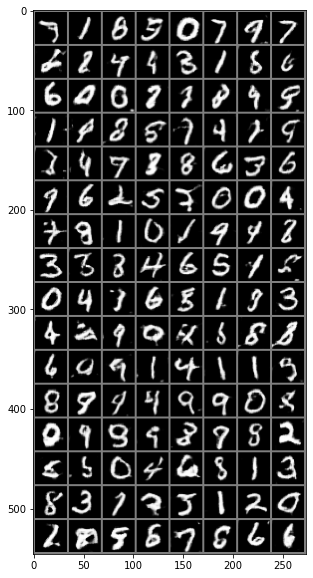

[Epoch 124/200] [Batch 68/468] [D loss: 49.885254] [G loss: 99.820587]
[Epoch 124/200] [Batch 168/468] [D loss: 50.000000] [G loss: 99.748108]
[Epoch 124/200] [Batch 268/468] [D loss: 49.864437] [G loss: 100.000000]
[Epoch 124/200] [Batch 368/468] [D loss: 49.933784] [G loss: 100.000000]
[Epoch 125/200] [Batch 0/468] [D loss: 49.873955] [G loss: 100.000000]
[Epoch 125/200] [Batch 100/468] [D loss: 50.000000] [G loss: 99.771210]
[Epoch 125/200] [Batch 200/468] [D loss: 49.906319] [G loss: 100.000000]
[Epoch 125/200] [Batch 300/468] [D loss: 49.911018] [G loss: 100.000000]
[Epoch 125/200] [Batch 400/468] [D loss: 49.817673] [G loss: 100.000000]
[Epoch 126/200] [Batch 32/468] [D loss: 49.950806] [G loss: 99.906815]
[Epoch 126/200] [Batch 132/468] [D loss: 49.935478] [G loss: 99.906219]
[Epoch 126/200] [Batch 232/468] [D loss: 50.000000] [G loss: 99.781235]
[Epoch 126/200] [Batch 332/468] [D loss: 50.000000] [G loss: 99.751060]
[Epoch 126/200] [Batch 432/468] [D loss: 49.895164] [G loss: 9

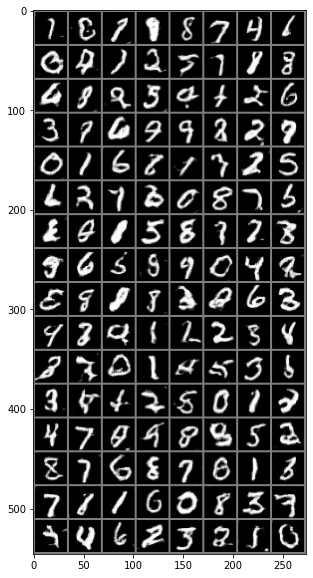

[Epoch 128/200] [Batch 196/468] [D loss: 49.889420] [G loss: 100.000000]
[Epoch 128/200] [Batch 296/468] [D loss: 49.925152] [G loss: 99.889107]
[Epoch 128/200] [Batch 396/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 129/200] [Batch 28/468] [D loss: 49.757057] [G loss: 99.813789]
[Epoch 129/200] [Batch 128/468] [D loss: 49.952255] [G loss: 100.000000]
[Epoch 129/200] [Batch 228/468] [D loss: 49.953575] [G loss: 99.900238]
[Epoch 129/200] [Batch 328/468] [D loss: 49.896976] [G loss: 99.875717]
[Epoch 129/200] [Batch 428/468] [D loss: 50.000000] [G loss: 99.855507]
[Epoch 130/200] [Batch 60/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 130/200] [Batch 160/468] [D loss: 49.890442] [G loss: 99.861084]
[Epoch 130/200] [Batch 260/468] [D loss: 49.894993] [G loss: 100.000000]
[Epoch 130/200] [Batch 360/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 130/200] [Batch 460/468] [D loss: 49.949318] [G loss: 100.000000]
[Epoch 131/200] [Batch 92/468] [D loss: 50.000000] [G loss:

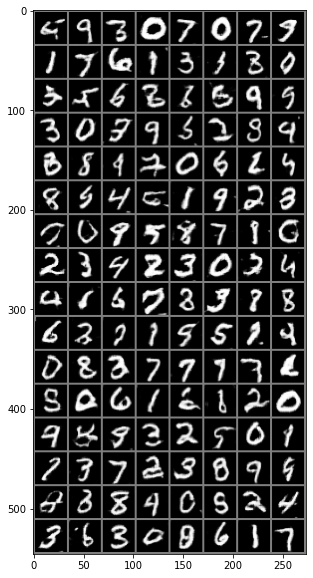

[Epoch 132/200] [Batch 324/468] [D loss: 49.883774] [G loss: 100.000000]
[Epoch 132/200] [Batch 424/468] [D loss: 49.954468] [G loss: 100.000000]
[Epoch 133/200] [Batch 56/468] [D loss: 49.955410] [G loss: 100.000000]
[Epoch 133/200] [Batch 156/468] [D loss: 49.815754] [G loss: 100.000000]
[Epoch 133/200] [Batch 256/468] [D loss: 49.893314] [G loss: 99.883644]
[Epoch 133/200] [Batch 356/468] [D loss: 50.000000] [G loss: 99.805161]
[Epoch 133/200] [Batch 456/468] [D loss: 50.000000] [G loss: 99.779182]
[Epoch 134/200] [Batch 88/468] [D loss: 49.939552] [G loss: 100.000000]
[Epoch 134/200] [Batch 188/468] [D loss: 49.756023] [G loss: 100.000000]
[Epoch 134/200] [Batch 288/468] [D loss: 50.000000] [G loss: 99.908859]
[Epoch 134/200] [Batch 388/468] [D loss: 49.927517] [G loss: 100.000000]
[Epoch 135/200] [Batch 20/468] [D loss: 50.000000] [G loss: 99.726860]
[Epoch 135/200] [Batch 120/468] [D loss: 49.899513] [G loss: 100.000000]
[Epoch 135/200] [Batch 220/468] [D loss: 49.737755] [G loss

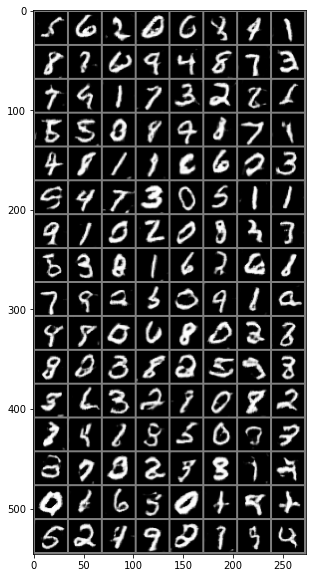

[Epoch 136/200] [Batch 452/468] [D loss: 49.917229] [G loss: 99.791756]
[Epoch 137/200] [Batch 84/468] [D loss: 49.955738] [G loss: 99.648071]
[Epoch 137/200] [Batch 184/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 137/200] [Batch 284/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 137/200] [Batch 384/468] [D loss: 49.952240] [G loss: 100.000000]
[Epoch 138/200] [Batch 16/468] [D loss: 49.952061] [G loss: 100.000000]
[Epoch 138/200] [Batch 116/468] [D loss: 49.925468] [G loss: 100.000000]
[Epoch 138/200] [Batch 216/468] [D loss: 49.892742] [G loss: 100.000000]
[Epoch 138/200] [Batch 316/468] [D loss: 49.778847] [G loss: 100.000000]
[Epoch 138/200] [Batch 416/468] [D loss: 49.885460] [G loss: 100.000000]
[Epoch 139/200] [Batch 48/468] [D loss: 49.944195] [G loss: 99.868454]
[Epoch 139/200] [Batch 148/468] [D loss: 49.928879] [G loss: 100.000000]
[Epoch 139/200] [Batch 248/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 139/200] [Batch 348/468] [D loss: 49.731453] [G lo

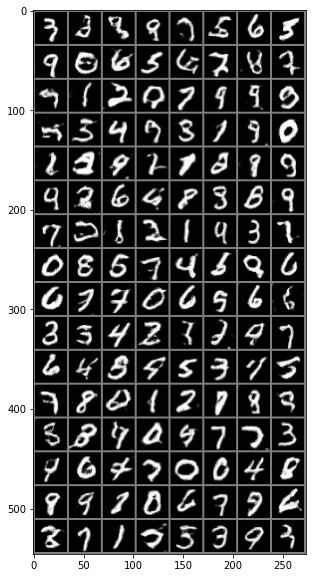

[Epoch 141/200] [Batch 112/468] [D loss: 49.904751] [G loss: 100.000000]
[Epoch 141/200] [Batch 212/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 141/200] [Batch 312/468] [D loss: 49.884361] [G loss: 100.000000]
[Epoch 141/200] [Batch 412/468] [D loss: 49.939079] [G loss: 100.000000]
[Epoch 142/200] [Batch 44/468] [D loss: 49.943001] [G loss: 99.560921]
[Epoch 142/200] [Batch 144/468] [D loss: 49.911045] [G loss: 100.000000]
[Epoch 142/200] [Batch 244/468] [D loss: 49.857826] [G loss: 100.000000]
[Epoch 142/200] [Batch 344/468] [D loss: 49.809612] [G loss: 100.000000]
[Epoch 142/200] [Batch 444/468] [D loss: 49.780472] [G loss: 100.000000]
[Epoch 143/200] [Batch 76/468] [D loss: 49.907417] [G loss: 99.854652]
[Epoch 143/200] [Batch 176/468] [D loss: 49.948837] [G loss: 99.883255]
[Epoch 143/200] [Batch 276/468] [D loss: 49.877678] [G loss: 100.000000]
[Epoch 143/200] [Batch 376/468] [D loss: 49.932377] [G loss: 99.897209]
[Epoch 144/200] [Batch 8/468] [D loss: 49.931557] [G loss

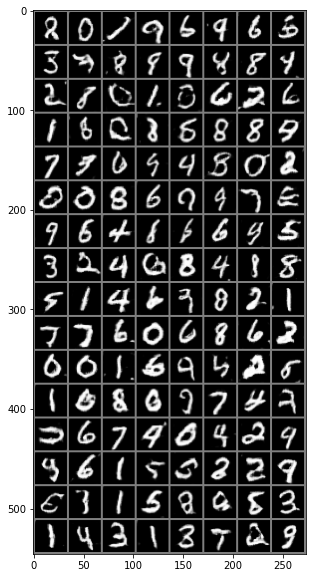

[Epoch 145/200] [Batch 240/468] [D loss: 49.887802] [G loss: 99.878914]
[Epoch 145/200] [Batch 340/468] [D loss: 49.954399] [G loss: 100.000000]
[Epoch 145/200] [Batch 440/468] [D loss: 50.000000] [G loss: 99.864815]
[Epoch 146/200] [Batch 72/468] [D loss: 49.889328] [G loss: 100.000000]
[Epoch 146/200] [Batch 172/468] [D loss: 49.762444] [G loss: 100.000000]
[Epoch 146/200] [Batch 272/468] [D loss: 49.953796] [G loss: 100.000000]
[Epoch 146/200] [Batch 372/468] [D loss: 50.000000] [G loss: 99.890343]
[Epoch 147/200] [Batch 4/468] [D loss: 49.946404] [G loss: 99.907463]
[Epoch 147/200] [Batch 104/468] [D loss: 50.000000] [G loss: 99.822655]
[Epoch 147/200] [Batch 204/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 147/200] [Batch 304/468] [D loss: 49.804527] [G loss: 100.000000]
[Epoch 147/200] [Batch 404/468] [D loss: 49.755325] [G loss: 99.838058]
[Epoch 148/200] [Batch 36/468] [D loss: 49.869331] [G loss: 100.000000]
[Epoch 148/200] [Batch 136/468] [D loss: 49.936630] [G loss: 

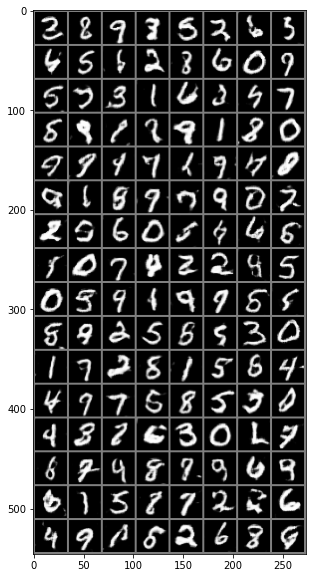

[Epoch 149/200] [Batch 368/468] [D loss: 49.942608] [G loss: 99.908745]
[Epoch 150/200] [Batch 0/468] [D loss: 49.882401] [G loss: 100.000000]
[Epoch 150/200] [Batch 100/468] [D loss: 49.903324] [G loss: 100.000000]
[Epoch 150/200] [Batch 200/468] [D loss: 49.884521] [G loss: 100.000000]
[Epoch 150/200] [Batch 300/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 150/200] [Batch 400/468] [D loss: 49.888340] [G loss: 100.000000]
[Epoch 151/200] [Batch 32/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 151/200] [Batch 132/468] [D loss: 50.000000] [G loss: 99.712738]
[Epoch 151/200] [Batch 232/468] [D loss: 49.889095] [G loss: 100.000000]
[Epoch 151/200] [Batch 332/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 151/200] [Batch 432/468] [D loss: 49.864304] [G loss: 100.000000]
[Epoch 152/200] [Batch 64/468] [D loss: 49.898376] [G loss: 100.000000]
[Epoch 152/200] [Batch 164/468] [D loss: 49.907608] [G loss: 100.000000]
[Epoch 152/200] [Batch 264/468] [D loss: 49.940804] [G lo

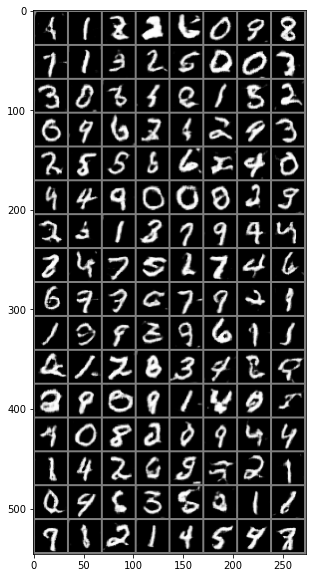

[Epoch 154/200] [Batch 28/468] [D loss: 49.771435] [G loss: 100.000000]
[Epoch 154/200] [Batch 128/468] [D loss: 49.766121] [G loss: 100.000000]
[Epoch 154/200] [Batch 228/468] [D loss: 49.869781] [G loss: 100.000000]
[Epoch 154/200] [Batch 328/468] [D loss: 49.895100] [G loss: 100.000000]
[Epoch 154/200] [Batch 428/468] [D loss: 49.789337] [G loss: 100.000000]
[Epoch 155/200] [Batch 60/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 155/200] [Batch 160/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 155/200] [Batch 260/468] [D loss: 49.794510] [G loss: 100.000000]
[Epoch 155/200] [Batch 360/468] [D loss: 49.890846] [G loss: 99.900757]
[Epoch 155/200] [Batch 460/468] [D loss: 49.882881] [G loss: 100.000000]
[Epoch 156/200] [Batch 92/468] [D loss: 49.885406] [G loss: 100.000000]
[Epoch 156/200] [Batch 192/468] [D loss: 49.951672] [G loss: 99.863708]
[Epoch 156/200] [Batch 292/468] [D loss: 49.872238] [G loss: 100.000000]
[Epoch 156/200] [Batch 392/468] [D loss: 49.952332] [G l

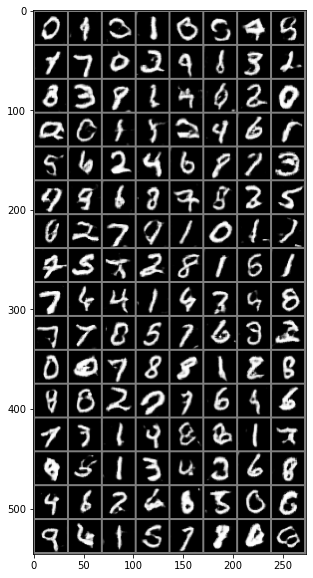

[Epoch 158/200] [Batch 156/468] [D loss: 49.897652] [G loss: 99.880203]
[Epoch 158/200] [Batch 256/468] [D loss: 49.872295] [G loss: 99.874474]
[Epoch 158/200] [Batch 356/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 158/200] [Batch 456/468] [D loss: 49.662312] [G loss: 100.000000]
[Epoch 159/200] [Batch 88/468] [D loss: 49.951241] [G loss: 99.868759]
[Epoch 159/200] [Batch 188/468] [D loss: 49.944592] [G loss: 99.883041]
[Epoch 159/200] [Batch 288/468] [D loss: 49.932343] [G loss: 100.000000]
[Epoch 159/200] [Batch 388/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 160/200] [Batch 20/468] [D loss: 50.000000] [G loss: 99.882523]
[Epoch 160/200] [Batch 120/468] [D loss: 50.000000] [G loss: 99.810242]
[Epoch 160/200] [Batch 220/468] [D loss: 49.930809] [G loss: 100.000000]
[Epoch 160/200] [Batch 320/468] [D loss: 49.869934] [G loss: 100.000000]
[Epoch 160/200] [Batch 420/468] [D loss: 49.954903] [G loss: 99.885910]
[Epoch 161/200] [Batch 52/468] [D loss: 49.667542] [G loss: 

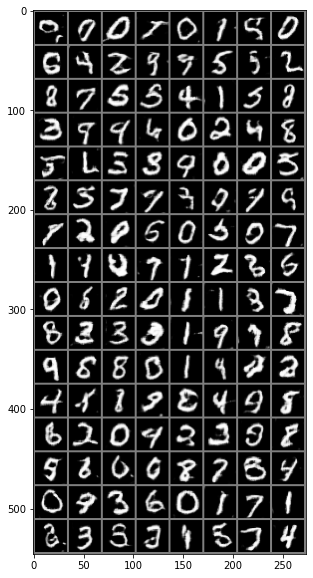

[Epoch 162/200] [Batch 284/468] [D loss: 49.911953] [G loss: 100.000000]
[Epoch 162/200] [Batch 384/468] [D loss: 49.847427] [G loss: 100.000000]
[Epoch 163/200] [Batch 16/468] [D loss: 49.951000] [G loss: 100.000000]
[Epoch 163/200] [Batch 116/468] [D loss: 50.000000] [G loss: 99.896797]
[Epoch 163/200] [Batch 216/468] [D loss: 49.925507] [G loss: 100.000000]
[Epoch 163/200] [Batch 316/468] [D loss: 49.949593] [G loss: 100.000000]
[Epoch 163/200] [Batch 416/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 164/200] [Batch 48/468] [D loss: 49.951866] [G loss: 99.747482]
[Epoch 164/200] [Batch 148/468] [D loss: 49.878639] [G loss: 99.884605]
[Epoch 164/200] [Batch 248/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 164/200] [Batch 348/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 164/200] [Batch 448/468] [D loss: 49.877800] [G loss: 100.000000]
[Epoch 165/200] [Batch 80/468] [D loss: 49.941833] [G loss: 100.000000]
[Epoch 165/200] [Batch 180/468] [D loss: 49.761795] [G lo

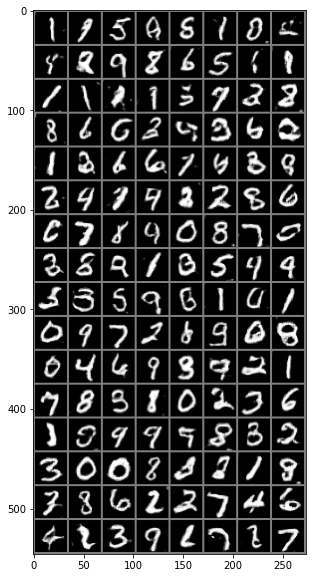

[Epoch 166/200] [Batch 412/468] [D loss: 49.951164] [G loss: 100.000000]
[Epoch 167/200] [Batch 44/468] [D loss: 49.924744] [G loss: 99.683586]
[Epoch 167/200] [Batch 144/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 167/200] [Batch 244/468] [D loss: 49.941833] [G loss: 100.000000]
[Epoch 167/200] [Batch 344/468] [D loss: 49.941780] [G loss: 100.000000]
[Epoch 167/200] [Batch 444/468] [D loss: 49.903709] [G loss: 99.839928]
[Epoch 168/200] [Batch 76/468] [D loss: 49.925385] [G loss: 99.803703]
[Epoch 168/200] [Batch 176/468] [D loss: 49.955410] [G loss: 100.000000]
[Epoch 168/200] [Batch 276/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 168/200] [Batch 376/468] [D loss: 49.873684] [G loss: 100.000000]
[Epoch 169/200] [Batch 8/468] [D loss: 49.677090] [G loss: 100.000000]
[Epoch 169/200] [Batch 108/468] [D loss: 49.928841] [G loss: 100.000000]
[Epoch 169/200] [Batch 208/468] [D loss: 49.881557] [G loss: 100.000000]
[Epoch 169/200] [Batch 308/468] [D loss: 49.690357] [G los

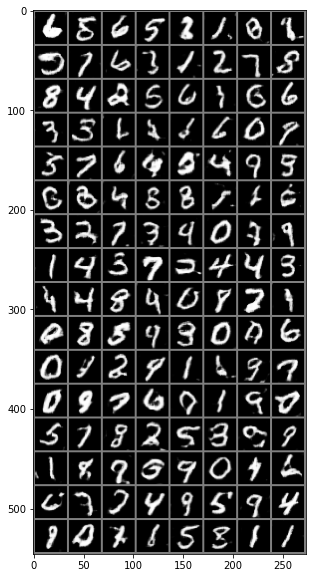

[Epoch 171/200] [Batch 72/468] [D loss: 50.000000] [G loss: 99.839203]
[Epoch 171/200] [Batch 172/468] [D loss: 49.939552] [G loss: 100.000000]
[Epoch 171/200] [Batch 272/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 171/200] [Batch 372/468] [D loss: 49.917797] [G loss: 99.902969]
[Epoch 172/200] [Batch 4/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 172/200] [Batch 104/468] [D loss: 49.889496] [G loss: 99.844910]
[Epoch 172/200] [Batch 204/468] [D loss: 49.676392] [G loss: 99.830910]
[Epoch 172/200] [Batch 304/468] [D loss: 49.940804] [G loss: 99.910324]
[Epoch 172/200] [Batch 404/468] [D loss: 49.950127] [G loss: 100.000000]
[Epoch 173/200] [Batch 36/468] [D loss: 49.885391] [G loss: 100.000000]
[Epoch 173/200] [Batch 136/468] [D loss: 49.832687] [G loss: 100.000000]
[Epoch 173/200] [Batch 236/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 173/200] [Batch 336/468] [D loss: 49.950630] [G loss: 100.000000]
[Epoch 173/200] [Batch 436/468] [D loss: 49.850441] [G loss:

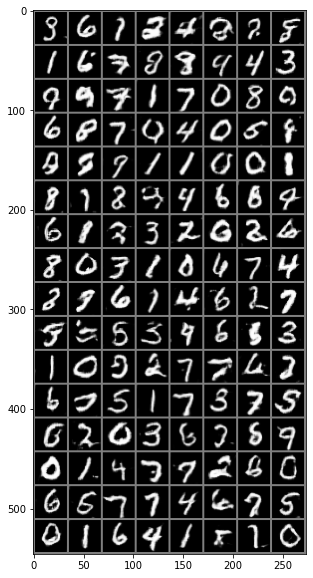

[Epoch 175/200] [Batch 200/468] [D loss: 49.849518] [G loss: 99.755646]
[Epoch 175/200] [Batch 300/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 175/200] [Batch 400/468] [D loss: 49.951130] [G loss: 99.891739]
[Epoch 176/200] [Batch 32/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 176/200] [Batch 132/468] [D loss: 49.936913] [G loss: 100.000000]
[Epoch 176/200] [Batch 232/468] [D loss: 49.740814] [G loss: 100.000000]
[Epoch 176/200] [Batch 332/468] [D loss: 49.706745] [G loss: 100.000000]
[Epoch 176/200] [Batch 432/468] [D loss: 49.953083] [G loss: 99.805084]
[Epoch 177/200] [Batch 64/468] [D loss: 49.898129] [G loss: 100.000000]
[Epoch 177/200] [Batch 164/468] [D loss: 50.000000] [G loss: 99.804703]
[Epoch 177/200] [Batch 264/468] [D loss: 50.000000] [G loss: 99.896759]
[Epoch 177/200] [Batch 364/468] [D loss: 49.940918] [G loss: 99.904724]
[Epoch 177/200] [Batch 464/468] [D loss: 49.925465] [G loss: 100.000000]
[Epoch 178/200] [Batch 96/468] [D loss: 49.896980] [G loss:

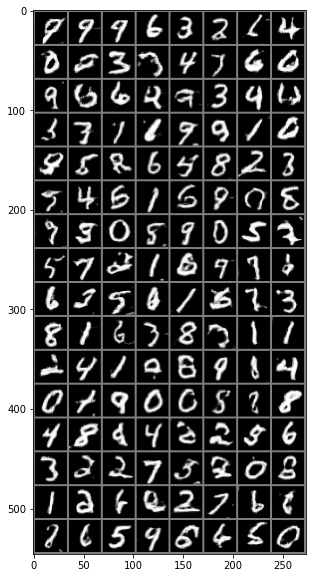

[Epoch 179/200] [Batch 328/468] [D loss: 49.901703] [G loss: 100.000000]
[Epoch 179/200] [Batch 428/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 180/200] [Batch 60/468] [D loss: 49.905418] [G loss: 100.000000]
[Epoch 180/200] [Batch 160/468] [D loss: 49.901718] [G loss: 100.000000]
[Epoch 180/200] [Batch 260/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 180/200] [Batch 360/468] [D loss: 49.948914] [G loss: 100.000000]
[Epoch 180/200] [Batch 460/468] [D loss: 49.854538] [G loss: 100.000000]
[Epoch 181/200] [Batch 92/468] [D loss: 49.941772] [G loss: 100.000000]
[Epoch 181/200] [Batch 192/468] [D loss: 49.941841] [G loss: 99.778732]
[Epoch 181/200] [Batch 292/468] [D loss: 49.841579] [G loss: 100.000000]
[Epoch 181/200] [Batch 392/468] [D loss: 49.949749] [G loss: 99.838699]
[Epoch 182/200] [Batch 24/468] [D loss: 49.899254] [G loss: 100.000000]
[Epoch 182/200] [Batch 124/468] [D loss: 49.808388] [G loss: 99.765846]
[Epoch 182/200] [Batch 224/468] [D loss: 50.000000] [G lo

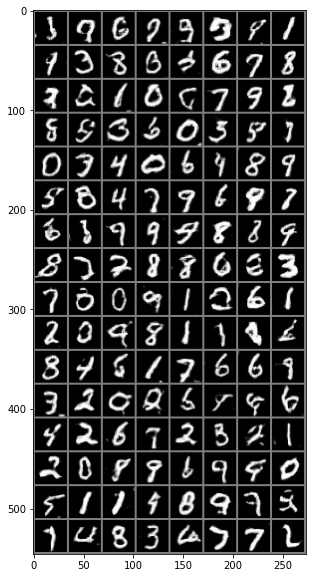

[Epoch 183/200] [Batch 456/468] [D loss: 49.940590] [G loss: 100.000000]
[Epoch 184/200] [Batch 88/468] [D loss: 49.848122] [G loss: 100.000000]
[Epoch 184/200] [Batch 188/468] [D loss: 49.950058] [G loss: 99.732712]
[Epoch 184/200] [Batch 288/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 184/200] [Batch 388/468] [D loss: 50.000000] [G loss: 99.905701]
[Epoch 185/200] [Batch 20/468] [D loss: 49.890690] [G loss: 99.872047]
[Epoch 185/200] [Batch 120/468] [D loss: 49.896362] [G loss: 99.813103]
[Epoch 185/200] [Batch 220/468] [D loss: 49.905205] [G loss: 100.000000]
[Epoch 185/200] [Batch 320/468] [D loss: 49.784256] [G loss: 100.000000]
[Epoch 185/200] [Batch 420/468] [D loss: 49.902573] [G loss: 99.794975]
[Epoch 186/200] [Batch 52/468] [D loss: 49.940315] [G loss: 99.900124]
[Epoch 186/200] [Batch 152/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 186/200] [Batch 252/468] [D loss: 50.000000] [G loss: 99.874390]
[Epoch 186/200] [Batch 352/468] [D loss: 49.918907] [G loss: 

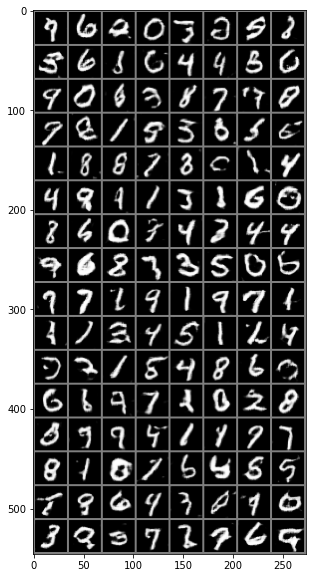

[Epoch 188/200] [Batch 116/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 188/200] [Batch 216/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 188/200] [Batch 316/468] [D loss: 50.000000] [G loss: 99.890884]
[Epoch 188/200] [Batch 416/468] [D loss: 49.896019] [G loss: 100.000000]
[Epoch 189/200] [Batch 48/468] [D loss: 50.000000] [G loss: 99.883636]
[Epoch 189/200] [Batch 148/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 189/200] [Batch 248/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 189/200] [Batch 348/468] [D loss: 49.939590] [G loss: 100.000000]
[Epoch 189/200] [Batch 448/468] [D loss: 49.903328] [G loss: 100.000000]
[Epoch 190/200] [Batch 80/468] [D loss: 49.736919] [G loss: 99.863396]
[Epoch 190/200] [Batch 180/468] [D loss: 49.943932] [G loss: 100.000000]
[Epoch 190/200] [Batch 280/468] [D loss: 49.892845] [G loss: 100.000000]
[Epoch 190/200] [Batch 380/468] [D loss: 49.850868] [G loss: 99.857468]
[Epoch 191/200] [Batch 12/468] [D loss: 49.955540] [G los

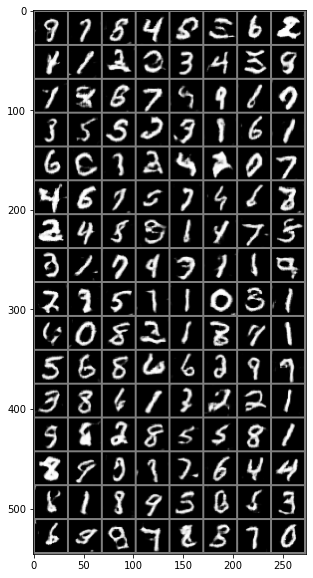

[Epoch 192/200] [Batch 244/468] [D loss: 49.946968] [G loss: 99.883583]
[Epoch 192/200] [Batch 344/468] [D loss: 49.952240] [G loss: 100.000000]
[Epoch 192/200] [Batch 444/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 193/200] [Batch 76/468] [D loss: 49.831688] [G loss: 100.000000]
[Epoch 193/200] [Batch 176/468] [D loss: 49.889839] [G loss: 100.000000]
[Epoch 193/200] [Batch 276/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 193/200] [Batch 376/468] [D loss: 49.934902] [G loss: 99.859978]
[Epoch 194/200] [Batch 8/468] [D loss: 49.948837] [G loss: 100.000000]
[Epoch 194/200] [Batch 108/468] [D loss: 49.895775] [G loss: 99.886360]
[Epoch 194/200] [Batch 208/468] [D loss: 49.955410] [G loss: 99.888550]
[Epoch 194/200] [Batch 308/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 194/200] [Batch 408/468] [D loss: 49.794537] [G loss: 100.000000]
[Epoch 195/200] [Batch 40/468] [D loss: 49.913910] [G loss: 100.000000]
[Epoch 195/200] [Batch 140/468] [D loss: 49.945751] [G loss

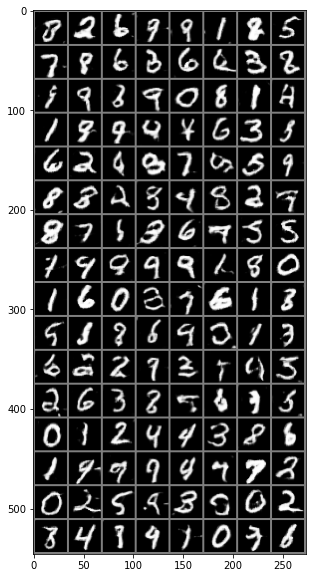

[Epoch 196/200] [Batch 372/468] [D loss: 50.000000] [G loss: 99.832642]
[Epoch 197/200] [Batch 4/468] [D loss: 49.938705] [G loss: 99.866196]
[Epoch 197/200] [Batch 104/468] [D loss: 49.862148] [G loss: 100.000000]
[Epoch 197/200] [Batch 204/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 197/200] [Batch 304/468] [D loss: 49.887901] [G loss: 100.000000]
[Epoch 197/200] [Batch 404/468] [D loss: 50.000000] [G loss: 99.899048]
[Epoch 198/200] [Batch 36/468] [D loss: 49.795250] [G loss: 99.911018]
[Epoch 198/200] [Batch 136/468] [D loss: 49.951485] [G loss: 100.000000]
[Epoch 198/200] [Batch 236/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 198/200] [Batch 336/468] [D loss: 50.000000] [G loss: 99.908997]
[Epoch 198/200] [Batch 436/468] [D loss: 50.000000] [G loss: 99.861977]
[Epoch 199/200] [Batch 68/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 199/200] [Batch 168/468] [D loss: 50.000000] [G loss: 100.000000]
[Epoch 199/200] [Batch 268/468] [D loss: 49.955296] [G loss: 

In [47]:
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):

        real_imgs = real_imgs.to(device)

        # Sample noise as generator input
        z = torch.Tensor(np.random.normal(0, 1, (real_imgs.shape[0], 100))).to(device)

        # -----------------
        #  Train Generator
        # -----------------
        #### Implement Here ####
        gen_imgs = G(z)
        ones = torch.ones((gen_imgs.size(0), 1)).to(device)
        zeros = torch.zeros((gen_imgs.size(0), 1)).to(device)
        
        optimizer_G.zero_grad()
        g_loss = criterion(D(gen_imgs), ones)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        #### Implement Here ####
        optimizer_D.zero_grad()
        fake_loss = criterion(D(gen_imgs.detach()), zeros)
        real_loss = criterion(D(real_imgs), ones)
        d_loss = (fake_loss + real_loss)/2
        d_loss.backward()
        optimizer_D.step()
        

        batches_done = epoch * len(dataloader) + i

        if batches_done % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        if batches_done % 2000 == 0:
            save_image(gen_imgs.data, "dcgan_images/%06d.png" % batches_done, nrow=8, normalize=True)
            imshow(torchvision.utils.make_grid(gen_imgs.cpu()))

## Inference
- Check noise space

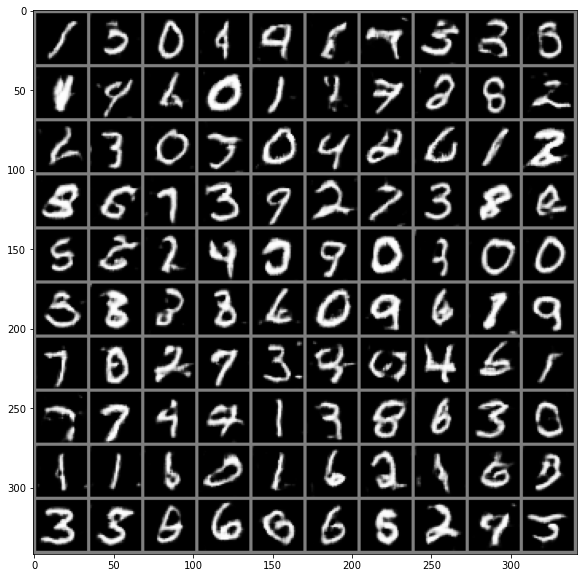

In [32]:
G.eval()
D.eval()

# 랜덤 노이즈(noise) 샘플링
z = torch.normal(mean=0, std=1, size=(100, 100)).to(device)

# 이미지 생성
gen_img = G(z)

imshow(torchvision.utils.make_grid(gen_img.detach().cpu(), nrow=10))

### Vector arithmetic 
- Pick three samples of cluster and take mean

In [33]:
ones = (z[0].unsqueeze(0) + z[84].unsqueeze(0) + z[74].unsqueeze(0)) / 3
sevens = (z[60].unsqueeze(0) + z[36].unsqueeze(0) + z[32].unsqueeze(0)) / 3
nines = (z[4].unsqueeze(0) + z[34].unsqueeze(0) + z[59].unsqueeze(0)) / 3

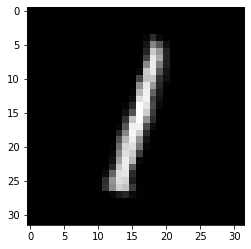

In [34]:
# ones
gen_img = G(ones).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

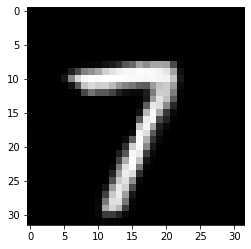

In [35]:
# sevens
gen_img = G(sevens).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

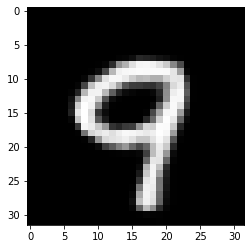

In [36]:
# twos
gen_img = G(nines).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

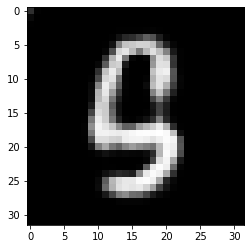

In [42]:
# vector_arithmetic
gen_vec = 
gen_img = G(gen_vec).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

### Noise Interpolation Visualize
- interpolate noise vector and visualize

torch.Size([10, 1, 32, 32])


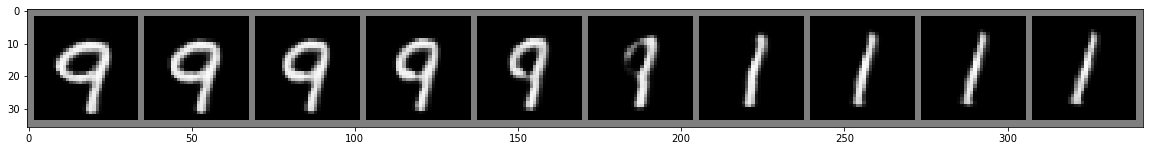

In [46]:
num_inter = 10
current = torch.Tensor(size=(num_inter, 100)).to(device)
for i in range(num_inter):
    current[i] = (ones.squeeze(0) * (i / (num_inter-1)) + nines.squeeze(0) * (((num_inter-1) - i) / (num_inter-1)))

gen_img = G(current).detach().cpu()
print(gen_img.shape)
imshow(torchvision.utils.make_grid(gen_img, nrow=num_inter))